In [1]:
## Grabbing data & initializing plotting parameters 
# @title Data retrieval
import os, requests
from HelperFunctions import path_check

fname = 'memory_nback.npz'
url = "https://osf.io/xfc7e/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
        
# @title Install packages (`nilearn`, `nimare`, `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True



#title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']


In [2]:
## Checking that an Output subfolder path exists, if not, creates the folder
cwd = os.getcwd()
import pandas as pd
OutPath = cwd + '/Output'
path_check.path_check(OutPath)



Directory  /Users/mairahmac/NMA2022_ECoG/NMA2022_ECoG/Code/Output  already exists


In [ ]:
## Saving metadata about each subject into a csv file 
metadata_list = ['Brodmann_Area', 'gyrus', 'lobe', 'hemisphere']

for i in range(len(alldat)):
    dat = (alldat[i][1])
    metadata_dict = dict((k, dat[k]) for k in metadata_list if k in metadata_list)
    metadata = pd.DataFrame.from_dict(metadata_dict)
    elecs = [*range(1, len(metadata)+1, 1)]
    metadata['elecs'] = elecs
    csvname = OutPath + '/Sub_' + str(i) + '_metadata.csv'
    
    metadata.to_csv(csvname, index = False)
    

In [20]:

## Iterating over all subjects for all blocks to make a new column that tells what the response type actually was 
## and adding it to the larger data dict
for m in range(len(alldat)):
    for j in range(len(alldat)):
        dat = (alldat[j][m])
        responseTypeList = []
        for i in range(len(dat['target'])):
            
            if dat['target'][i] == 0 & dat['response'][i] == 1:
                responseTypeList.append('FalseAlarm')
            elif  dat['target'][i] == 1 & dat['response'][i] == 1:
                responseTypeList.append('TargetHit')
            elif dat['target'][i] == 0 & dat['response'][i] == 0:
                responseTypeList.append('CorrectRejection')
            elif dat['target'][i] == 1 & dat['response'][i] == 0:
                responseTypeList.append('TargetMiss')
            else: 
                continue
        dat['responseType'] = responseTypeList
        print(dat['responseType'])
        

        

[]
[]
[]
['CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'TargetHit', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'TargetHit', 'TargetHit', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'TargetHit', 'CorrectRejection', 'TargetHit', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'TargetHit', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'TargetHit', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'TargetHit', 'CorrectRejection', 'TargetHit', 'TargetHit', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'TargetHit', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'CorrectRejection', 'Target

/var/folders/nb/qns58gm53h1btptlry8cnm640000gn/T/ipykernel_22428/611368546.py:34: RuntimeWarning: Mean of empty slice.
  V_falseAlarm = (V_epochs[dat['responseType'] == 'FalseAlarm']).mean(0)
/Users/mairahmac/opt/anaconda3/envs/NMA/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/nb/qns58gm53h1btptlry8cnm640000gn/T/ipykernel_22428/611368546.py:36: RuntimeWarning: Mean of empty slice.
  V_corrRej    = (V_epochs[dat['responseType'] == 'CorrectRejection']).mean(0)
/var/folders/nb/qns58gm53h1btptlry8cnm640000gn/T/ipykernel_22428/611368546.py:37: RuntimeWarning: Mean of empty slice.
  V_tarHit     = (V_epochs[dat['responseType'] == 'TargetHit']).mean(0)
/var/folders/nb/qns58gm53h1btptlry8cnm640000gn/T/ipykernel_22428/611368546.py:38: RuntimeWarning: Mean of empty slice.
  V_tarMiss    = (V_epochs[dat['responseType'] == 'TargetMiss']).mean(0)


80
False
(100, 2000, 64)
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan na

ValueError: x and y must have same first dimension, but have shapes (2000,) and (100, 64)

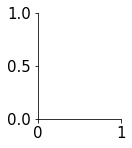

In [22]:
## Generating plots of 
# compute spectral power above 70Hz and low-pass below 0.5Hz
# power is always positive, so we normalize it by its average
from scipy import signal

for m in range(len(alldat)):
    for i in range(len(alldat)):
        dat = (alldat[i][m])
        if dat['expinfo'] != 'fixation': 
            blocktype = dat['expinfo']
            V = dat['V'].astype('float32') # always convert the voltage data to float32!

            # high-pass filter above 50 Hz
            b, a = signal.butter(3, [70], btype='high', fs=1000)
            V = signal.filtfilt(b, a, V, 0)

            # compute smooth envelope of this signal = approx power
            V = np.abs(V)**2
            b, a = signal.butter(3, [0.5], btype='low', fs=1000)
            V = signal.filtfilt(b, a, V, 0)

            # normalize each channel so its mean power is 1
            V = V/V.mean(0)

            # divide into trials and average
            nt, nchan = V.shape
            nstim = len(dat['t_on'])

            # use a timerange from 400ms before to 1600ms after the stimulus onset
            trange = np.arange(-400, 1600)
            ts = dat['t_on'][:, np.newaxis] + trange
            V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

            V_falseAlarm = (V_epochs[dat['responseType'] == 'FalseAlarm']).mean(0)
            V_FA_noMean  = (V_epochs[dat['responseType'] == 'FalseAlarm'])
            V_corrRej    = (V_epochs[dat['responseType'] == 'CorrectRejection']).mean(0)
            V_tarHit     = (V_epochs[dat['responseType'] == 'TargetHit']).mean(0)
            V_tarMiss    = (V_epochs[dat['responseType'] == 'TargetMiss']).mean(0)
            responsetypeslist = [V_falseAlarm, V_corrRej, V_tarHit, V_tarMiss]
            print(len(responseTypeList))
            print(dat['responseType'] == 'FalseAlarm')
            print(V_epochs.shape)
            print(V_corrRej[0:5])

            # let's find the electrodes that distinguish responses from non-responses
            # note these are event-related potentials
            figname = OutPath + '/Sub_' + str(i) + '_' + blocktype + '.jpg'
            plt.figure(figsize=(15, 12))
            for j in range(60):
              ax = plt.subplot(6, 10, j+1)
              plt.plot(trange, V_tarHit[:, j], lw=2, color='green')
              plt.plot(trange, V_corrRej[:, j], lw=2, color='blue')
              plt.plot(trange, V_falseAlarm[:, j], lw=2, color='red')
              plt.plot(trange, V_tarMiss[:, j], lw=2, color='black')
              plt.title('ch%d'%j)
              plt.yticks([])
              plt.ylim([0, 3])
            plt.savefig(figname)


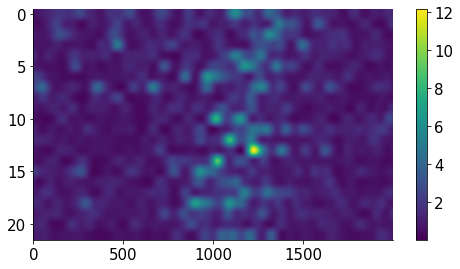

In [ ]:
# let's look at all the response trials for the electrode that has a significant response
plt.subplot(1, 3, 1)
plt.imshow(V_epochs[dat['response']==1, :, 21].astype('float32'),
           aspect='auto')
plt.colorbar()
plt.show()

In [ ]:
# to do: do these responses covary with the reaction times? are they present on trials where there is no motor response?